In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries imported.")

✅ Libraries imported.


## 1. Load Data

In [51]:
data_path = 'data'
X_test = np.load(f'{data_path}/X_test.npy')
y_test = np.load(f'{data_path}/y_test.npy')
feature_names = np.load(f'{data_path}/feature_names.npy', allow_pickle=True)

print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_test: (12151, 10), y_test: (12151,)


## 2. Load Model Results

In [52]:
try:
    single_results = pd.read_csv('outputs/single_models_results.csv', index_col=0)
    single_results['type'] = 'Single'
except FileNotFoundError:
    print("Single model results not found.")
    single_results = pd.DataFrame()

try:
    ensemble_results = pd.read_csv('outputs/ensemble_models_results.csv', index_col=0)
    ensemble_results['type'] = 'Ensemble'
except FileNotFoundError:
    print("Ensemble model results not found.")
    ensemble_results = pd.DataFrame()

all_results = pd.concat([single_results, ensemble_results])
all_results = all_results.sort_values('f1', ascending=False)

print("model_summary:")
print(all_results[['type', 'accuracy', 'recall', 'f1', 'roc_auc']])
all_results.to_csv('outputs/final_model_summary.csv')

model_summary:
                        type  accuracy    recall        f1   roc_auc
Stacking            Ensemble  0.819933  0.778819  0.809706  0.910417
LightGBM            Ensemble  0.818945  0.775807  0.808262  0.910866
XGBoost             Ensemble  0.819521  0.772461  0.808086  0.910483
RandomForest        Ensemble  0.817546  0.773298  0.806561  0.908971
Voting              Ensemble  0.814830  0.775473  0.804688  0.903806
DecisionTree          Single  0.816311  0.764932  0.803797  0.908379
KNN                   Single  0.806600  0.765267  0.795617  0.892380
LogisticRegression    Single  0.753024  0.715744  0.740331  0.825078
NaiveBayes            Single  0.738540  0.707378  0.726898  0.795881


## 3. Best Model Analysis


Best Model: Stacking (Ensemble)
Loading model from: models/ensemble_stacking.pkl
✅ Model loaded successfully.


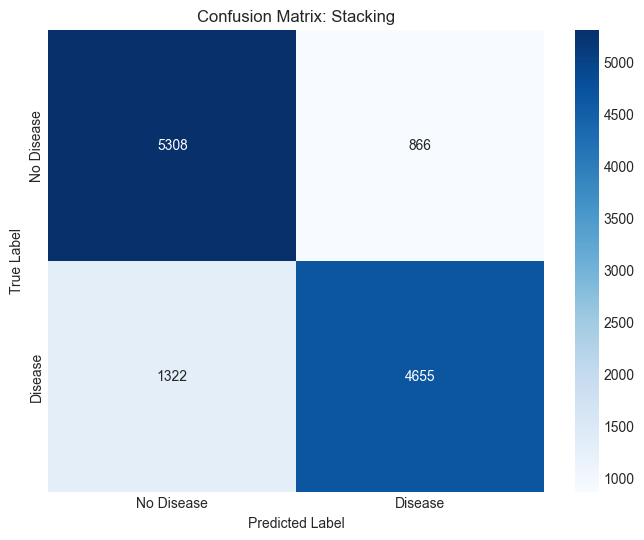

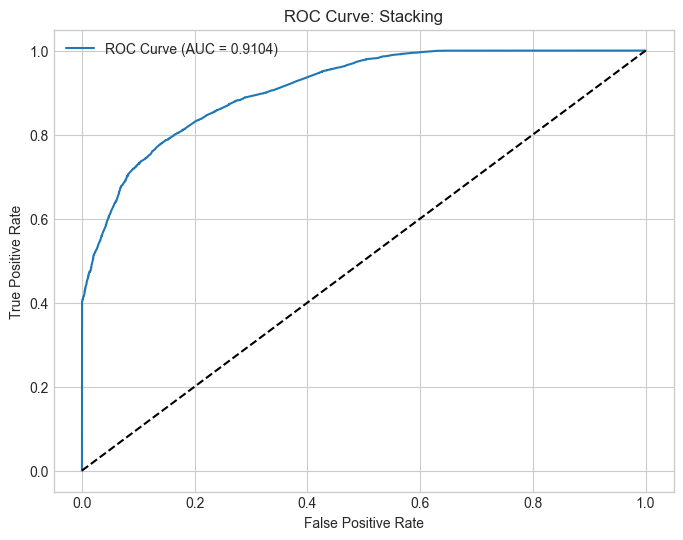


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      6174
           1       0.84      0.78      0.81      5977

    accuracy                           0.82     12151
   macro avg       0.82      0.82      0.82     12151
weighted avg       0.82      0.82      0.82     12151



In [53]:
if not all_results.empty:
    best_model_name = all_results.index[0]
    best_model_type = all_results.iloc[0]['type']
    print(f"\nBest Model: {best_model_name} ({best_model_type})")
    
    # Determine filename
    model_filename = f"models/{best_model_type.lower()}_{best_model_name.lower()}.pkl"
    print(f"Loading model from: {model_filename}")
    
    try:
        model = joblib.load(model_filename)
        print("✅ Model loaded successfully.")
        
        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
        plt.title(f'Confusion Matrix: {best_model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('outputs/confusion_matrix.png')
        plt.show()
        
        # ROC Curve
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_val = roc_auc_score(y_test, y_proba)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_val:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {best_model_name}')
            plt.legend()
            plt.savefig('outputs/roc_curve.png')
            plt.show()
            
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature Importance (if available)
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            plt.figure(figsize=(10, 6))
            plt.title(f"Feature Importances ({best_model_name})")
            plt.bar(range(len(importances)), importances[indices], align="center")
            plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
            plt.tight_layout()
            plt.savefig('outputs/feature_importance.png')
            plt.show()
            
    except Exception as e:
        print(f"Error loading or evaluating model: {e}")
else:
    print("No results to evaluate.")